In [1]:
# notebook to pinpoint degradation, rapid fire some more ideas, using noun setting

In [1]:
import pickle
from encode_utils.rerank_data import rerank_dist, rerank_single
from encode_utils.efficient_rerank import get_effrerank_model, run_comstyle
from encode_utils.sco_funct import weightaddprob, default_scofunct
from encode_utils.mt_scores import get_scores_auto
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import torch
import random
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


2022-12-19 05:44:28.260715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 05:44:28.260738: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# get graph to examine
ind = 3
#base = "outputs/graph_pickles/frenchbeam50_reversed/"
base = "outputs/graph_pickles/frtest_reversed/"
graph = pickle.load(open(base+str(ind), 'rb'))

In [3]:
# get exploded paths, scored, for the graph
#noun_explode = pd.read_csv("outputs/score_csvs/frenbeam50v1.csv")
noun_explode = pd.read_csv("outputs/score_csvs/nounexplodev1.csv")
texplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
bestcand = np.argmax(list(texplode['utnoun']))
bestcand = texplode.iloc[bestcand]

In [19]:
bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
            flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':useall}, True)
predhyp = bestpath[0][4:]

here


In [36]:
bestcand

index                                                      108283
Unnamed: 0                                                 108283
src             Il nous faut négocier un nouvel accord de part...
ref             A new Partnership and Cooperation Agreement (P...
hyp             We need to negotiate a new Partnership and Coo...
utnoun                                                   1.255471
unique_nouns                                                   12
Name: 300, dtype: object

In [4]:
# load the model
encodemod = get_effrerank_model("noun")
xlm_tok = AutoTokenizer.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


freeze embeds


In [5]:
def randomsingle(mask, row, checknodes, mlen):
    if row>0:
        avail = []
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                avail.append(n)
        if len(avail)==0:
            print(len(checknodes))
            print(row)
        mask[row][random.choice(avail).canvpos] = 1
        
def useall(mask, row, checknodes, mlen):
    if row>0:
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                mask[row][n.canvpos] = 1
        
# randomly use nodes, but possibility of more than one previous node being used
def randommulti(mask, row, checknodes, mlen):
    if row>0:
        avail = []
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                avail.append(n)
        if len(avail)==0:
            print(len(checknodes))
            print(row)
        #mask[row][random.choice(avail).canvpos] = 1
        
        tosamp = random.randint(1, len(avail))
        samp = random.sample(avail, tosamp)
        # use next with highest prob
        for n in samp:
            if n.canvpos<mlen: # keep within bounds
                mask[row][n.canvpos] = 1 

In [59]:
# score check (at token level) the best option, and the new option (should be same until they get to non-identical tokens)

SETLEN = 457

# get token level scores from model
def get_hyp_sco(inphyp, posids=None):
    
    tokens = xlm_tok(inphyp, return_tensors='pt').to(device)
    tokens = tokens.input_ids
    if posids is None: 
        positionids = torch.arange(len(tokens[0])).unsqueeze(0).to(device)
    else:
        # get token at the end
        positionids = torch.tensor(posids+[posids[-1]+1]).unsqueeze(0).to(device)
    tmpmask = torch.tril(torch.ones(len(tokens[0]), len(tokens[0]))).unsqueeze(0).to(device)
    #print(tokens.shape)
    #print(positionids.shape)
    #print()
    #print(tokens.shape)
    #print(torch.max(positionids))
    toked_inp = xlm_tok(["noun"], return_tensors="pt").to(device)
    predout = encodemod(toked_inp.input_ids, toked_inp.attention_mask, tokens, positionids, \
        tmpmask)
    tmppred = predout['score']
    #norm = predout['norm']
    return tmppred

# test out reranking multiple EEL outputs (observe improvements)
def lattice_multi_rerank(ind, n):
    # get graph, get the "best candidate"
    graph = pickle.load(open(base+str(ind), 'rb'))
    nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
    print(len(nexplode))
    if len(nexplode)==0:
        return None
    bestcand = np.argmax(list(nexplode['utnoun']))
    bestcand = nexplode.iloc[bestcand]
    
    goldsco = get_hyp_sco(bestcand['hyp'])
    goldsco = torch.sum(goldsco[0])
    bpred = -100
    bhyp = ""
    ascos = []
    ahyps = []
    numnodes = 0
    for i in range(n):
        graph = pickle.load(open(base+str(ind), 'rb'))
        # generate with model
        bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
            flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':useall}, True)
        predhyp = bestpath[0][4:]
        hypsco = torch.sum(get_hyp_sco(predhyp)[0])
        if hypsco>bpred:
            bpred = hypsco
            bhyp = predhyp
        ascos.append(hypsco)
        ahyps.append(predhyp)
        numnodes = len(flattened)
    return bpred, bhyp, goldsco, bestcand['hyp'], ascos, ahyps, numnodes

# get multiple things with the lattice, rerank on each (not optimized, so it is a bit slow)
def all_lattice_multi(n):
    pdistr = []
    cnt = 0
    for i in range(SETLEN):
        try:
            outval = lattice_multi_rerank(i, n)
        except:
            continue
        if outval==None:
            continue
        else:
            print(cnt, " ", i, " ", outval[0], " ", outval[2], " ")
            pdistr.append({
                'hyp':outval[1],
                'hypsco':outval[0],
                'gold':outval[3],
                'goldsco':outval[2],
                'ascos':[float(f) for f in outval[4]],
                'ahyps':outval[5],
                'numnodes':outval[6]
            })
            cnt+=1
    res = pd.DataFrame(pdistr)
    return res

# rerank given a random sample
def all_unnoun_multi():
    pdistr = []
    cnt = 0
    for i in range(SETLEN):
        try:
            graph = pickle.load(open(base+str(i), 'rb'))
        except:
            break
        nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
        if len(nexplode)==0:
            continue
        nexplode = nexplode.sample(n=51)
        assert len(nexplode)==51
        bestcand = np.argmax(list(nexplode['utnoun']))
        bestcand = nexplode.iloc[bestcand]

        goldsco = get_hyp_sco(bestcand['hyp'])
        goldsco = torch.sum(goldsco[0])
        pdistr.append(goldsco)
    
    return pdistr

In [ ]:
unnoun = all_unnoun_multi()

In [39]:
len(unnoun)

99

In [40]:
mean(unnoun)

tensor(0.8715, device='cuda:1', grad_fn=<DivBackward0>)

In [ ]:
allmulti = all_lattice_multi(1)

In [31]:
# allmulti.to_csv("outputs/predcsvs/noun_comstyle_beam50.csv")

In [49]:
len(allmulti)

99

In [41]:
allmulti = pd.read_csv("outputs/predcsvs/noun_comstyle_multi_32.csv")

In [46]:
oldamult = allmulti

In [58]:
# gold values are the same...
for i in range(len(allmulti)):
    if allmulti['gold'].iloc[i] not in oldamult['gold'].iloc[i]:
        print("bad")

In [51]:
import re
def mean(l):
        
    l = list(l)
    if type(l[0]) is str:
        l = [float(re.findall("\d+\.\d+", lent)[0]) for lent in l]
    return sum(l)/len(l)

mean(allmulti['hypsco'])

tensor(0.8799, device='cuda:1', grad_fn=<DivBackward0>)

In [41]:
allmulti['unoun'] = [float(f) for f in unnoun]

In [31]:
allmulti['hypsco']  = [float(re.findall("\d+\.\d+", lent)[0]) for lent in allmulti['hypsco']]

In [32]:
allmulti['goldsco']  = [float(re.findall("\d+\.\d+", lent)[0]) for lent in allmulti['goldsco']]

In [19]:
import matplotlib.pyplot as plt

(array([ 1.,  1.,  3., 22., 18., 28., 16.,  5.,  3.,  2.]),
 array([-0.16865671, -0.11990161, -0.07114651, -0.02239141,  0.02636368,
         0.07511878,  0.12387388,  0.17262897,  0.22138407,  0.27013917,
         0.31889427]),
 <BarContainer object of 10 artists>)

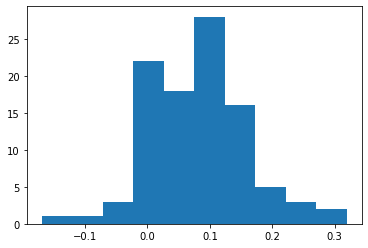

In [62]:
plt.hist([float(f) for f in list(allmulti['goldsco']-allmulti['hypsco'])])

In [85]:
len(allmulti[allmulti['numnodes']>512])

35

In [74]:
allmulti[allmulti['goldsco']-allmulti['hypsco']>.2]['gold'].iloc[6]

'At a time when all nations are facing their own challenges, there is a need to forge a common agenda at the global level that will ensure that the seven billionth baby and future generations grow up in a world of peace, prosperity, freedom and justice that lasts.'

In [24]:
mean(allmulti['hypsco'])

tensor(0.8882, device='cuda:1', grad_fn=<DivBackward0>)

In [8]:
ind = 3
# get model output
graph = pickle.load(open(base+str(ind), 'rb'))
sco_funct = default_scofunct
bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
        flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, sco_funct, "noun", {'afunc':randomsingle}, True)
predhyp = bestpath[0][4:]
print("generated - \n"+predhyp)

here
generated - 
We need to negotiate a new Partnership and Cooperation Agreement (PCA) between the European Union and the Russian Federation, following the suspension of the talks due to start last year have been suspended because of the war in Georgia.


In [9]:
bestsco = get_hyp_sco(bestcand['hyp'])
hypsco = get_hyp_sco(predhyp)
print(bestcand['hyp'])
print(torch.sum(bestsco[0]))
print(predhyp)
print(torch.sum(hypsco[0]))
print(bsco)

here
here
We need to negotiate a new Partnership and Cooperation Agreement (PCA), between the European Union and the Russian Federation, following the suspension of talks to begin last year were suspended because of the war in Georgia.
tensor(1.2150, device='cuda:1', grad_fn=<SumBackward0>)
We need to negotiate a new Partnership and Cooperation Agreement (PCA) between the European Union and the Russian Federation, following the suspension of the talks due to start last year have been suspended because of the war in Georgia.
tensor(1.2311, device='cuda:1', grad_fn=<SumBackward0>)
[tensor([1.3037], device='cuda:1')]


In [122]:
bestcand

index                                                      108283
Unnamed: 0                                                 108283
src             Il nous faut négocier un nouvel accord de part...
ref             A new Partnership and Cooperation Agreement (P...
hyp             We need to negotiate a new Partnership and Coo...
utnoun                                                   1.255471
unique_nouns                                                   12
Name: 300, dtype: object

In [10]:
# sanity check that masks are functioning in an ok way (passed)
def mask_sanity(msk, inps, posids):
    allinps = []
    allpos = []
    for m in msk:
        # get spare
        tmptoks = []
        tmppos = []
        for t in range(len(m)):
            if m[t]!=0:
                tmptoks.append(inps[t])
                tmppos.append(posids[t])
        resort = sorted(zip(tmppos, tmptoks))
        tmptoks = [x for _,x in resort]
        tmppos = [x for x, _ in resort]
        allinps.append(torch.tensor(tmptoks).int())
        allpos.append(tmppos)
    return allinps, allpos

In [78]:
a = [1, 2]
b = ['a', 'b']
c = zip(a, b)

In [79]:
list(c)

[(1, 'a'), (2, 'b')]

In [16]:
# score check (at token level) the best option, and the new option (should be same until they get to non-identical tokens)

# get token level scores from model
def get_hyp_sco_verb(inphyp, posids=None):
    
    tokens = xlm_tok(inphyp, return_tensors='pt').to(device)
    tokens = tokens.input_ids
    #print(inphyp)
    #print(tokens)
    if posids is None: 
        positionids = torch.arange(len(tokens[0])).unsqueeze(0).to(device)
    else:
        # get token at the end
        positionids = torch.tensor(posids+[posids[-1]+1]).unsqueeze(0).to(device)
    #print(positionids)
    tmpmask = torch.tril(torch.ones(len(tokens[0]), len(tokens[0]))).unsqueeze(0).to(device)
    #print(tokens.shape)
    #print(positionids.shape)
    #print()
    #print(tokens.shape)
    #print(torch.max(positionids))
    toked_inp = xlm_tok(["noun"], return_tensors="pt").to(device)
    predout = encodemod(toked_inp.input_ids, toked_inp.attention_mask, tokens, positionids, \
        tmpmask)
    tmppred = predout['score']
    #norm = predout['norm']
    return tmppred, tokens, positionids, tmpmask

In [12]:
ainps, apos = mask_sanity(mask, sents[0], posids[0])

In [13]:
testsens = xlm_tok.batch_decode(ainps)

In [20]:
index = 40
#print(apos[index])
p_pred, p_tok, p_pos, p_mask = get_hyp_sco_verb(testsens[index][4:], apos[index])
n_pred, n_tok, n_pos, n_mask = get_hyp_sco_verb(testsens[index][4:], None)

here
here


In [21]:
list(zip([float(f) for f in p_pred[0]], [float(f) for f in n_pred[0]]))

[(0.0, 0.0),
 (0.0007452319841831923, 0.0007105700206011534),
 (0.0006145313382148743, 0.0005859484663233161),
 (0.0007824336062185466, 0.000746041361708194),
 (0.0009718615328893065, 0.0009266586857847869),
 (0.003711999161168933, 0.0035393480211496353),
 (0.001512863440439105, 0.001442497712559998),
 (0.0007613550405949354, 0.0007259431877173483),
 (0.00079939333954826, 0.000762212264817208),
 (0.017123648896813393, 0.016327200457453728),
 (0.003832751652225852, 0.0036544841714203358),
 (0.004214657936245203, 0.004018627107143402),
 (0.02993575483560562, 0.028543394058942795),
 (0.004783897660672665, 0.004561391193419695),
 (0.03646809235215187, 0.03477190434932709),
 (0.006932106800377369, 0.00660968292504549),
 (0.044528160244226456, 0.042457081377506256),
 (0.00988731812685728, 0.009427443146705627),
 (0.011662271805107594, 0.011119840666651726),
 (0.019538961350917816, 0.018630173057317734),
 (0.012992732226848602, 0.012388419359922409),
 (0.03538692742586136, 0.03374102339148521

In [22]:
pred1, tok1, pos1, mask1 = get_hyp_sco_verb("I am nice")
pred2, tok2, pos2, mask2 = get_hyp_sco_verb("I am cool")


here
here


In [24]:
print(pred1)
print(pred2)

tensor([[[0.0000],
         [0.0074],
         [0.0029],
         [0.0081],
         [0.0036]]], device='cuda:1', grad_fn=<DivBackward0>)
tensor([[[0.0000],
         [0.0074],
         [0.0029],
         [0.0080],
         [0.0054]]], device='cuda:1', grad_fn=<DivBackward0>)


In [26]:
fpos = []
for pl in apos:
    tmp = []
    for p in pl:
        tmp.append(int(p))
    fpos.append(tmp)

In [ ]:
# pos ids as a source of degradation?
for i in range(1, len(fpos)):
    for j in range(1, len(fpos[i])):
        if fpos[i][j] is not fpos[i][j-1]+1:
            print("off at ", i, " ", fpos[i][j-1], " ",fpos[i][j] )

In [ ]:
fpos[40:]

In [21]:
def test_graph_ind(base, ind, model, funct, outfile):
    graph = pickle.load(open(base+str(ind), 'rb'))
    return {
        'hyp':run_comstyle(graph, model, funct, outfile, False)[0],
        'ref':graph['ref'],
        'src':graph['input']
    }

In [ ]:
import pandas as pd
from encode_utils.rerank_data import rerank_dist, rerank_single
from encode_utils.mt_scores import get_scores_auto
from encode_utils.sco_funct import weightaddprob, default_scofunct

from test_efficient_rerank import test_graph_ind

In [3]:
def mean(l):
    return sum(l)/len(l)

In [3]:
noun_explode = pd.read_csv("outputs/score_csvs/nounexplodev1.csv")

In [6]:
gold_vals = rerank_dist(noun_explode, rerank_single, ['utnoun', 'utnoun'])

In [40]:
# get model 


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


In [45]:
res = test_graph_ind("outputs/graph_pickles/frtest_reversed/", 0, encodemod, default_scofunct, "noun")

In [46]:
res

{'hyp': '<s> After all, as a field investigative journalist, she has instilled in many people besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, not the least of whom she has accused of conducting a policy of abduction for ransom.',
 'ref': 'After all, as a campaigning investigative journalist she made many people angry besides Putin, not least of which is the current Chechen Prime Minister, Ramzan Kadyrov, whom she accused of a policy of kidnapping for ransom. ',
 'src': "Après tout, en tant que journaliste d'investigation en campagne, elle a enragé beaucoup d'autres gens outre Poutine, parmi lesquels l'actuel Premier ministre tchétchène Ramzan Kadyrov n'est pas des moindres, qu'elle a accusé de mener une politique d'enlèvements contre rançons. "}

In [ ]:
get_scores_auto([res['hyp'][4:]], ["noun"], [], "utnoun", "comstyle")

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
npreds = pd.read_csv("outputs/predcsvs/noun_comstyle_v2.csv")

In [21]:
uns = list(noun_explode['ref'].unique())

In [49]:
res = []
for u in uns: 
    res.append(float(npreds[npreds['ref']==u]['utnoun']))

In [50]:
mean(res)

0.8628873924911022

In [56]:
diffs = [gold_vals[i] - res[i] for i in range(len(res))]

In [58]:
mean(diffs)

0.08779214024543762

In [59]:
import matplotlib.pyplot as plt

(array([ 1.,  1.,  1., 21., 17., 32., 15.,  8.,  3.,  1.]),
 array([-0.16788018, -0.11897451, -0.07006885, -0.02116318,  0.02774248,
         0.07664815,  0.12555381,  0.17445948,  0.22336514,  0.2722708 ,
         0.32117647]),
 <BarContainer object of 10 artists>)

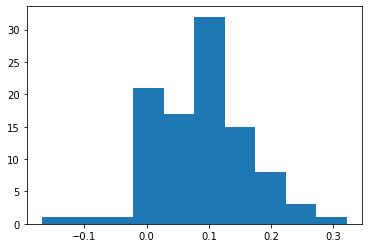

In [60]:
plt.hist(diffs)

In [62]:
for i in range(len(diffs)):
    if diffs[i]<0:
        print(i)

13
24
29
30
75


In [75]:
hyp = npreds[npreds['ref']==uns[13]]['ahyp'].iloc[0]

In [79]:
noun_explode[noun_explode['ref']==uns[13]]

,Unnamed: 0,src,ref,hyp,utnoun,unique_nouns
27070,27070,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards much mo...,0.393927,5
27071,27071,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to much more re...,0.383695,4
27072,27072,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to a much more ...,0.398260,4
27073,27073,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards a much ...,0.409214,4
27074,27074,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards far mor...,0.390841,5
...,...,...,...,...,...,...
28342,28342,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards far mor...,0.621482,8
28343,28343,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path toward much mor...,0.623692,7
28344,28344,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to far more res...,0.606072,7
28345,28345,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards much mo...,0.623454,8


In [80]:
hyp

'In the absence of a clear path towards a much more restrictive financial and political union, which can only be achieved by means of a constitutional change, the euro system’s current “transition house" of the euro system looks increasingly unsustainable.'

In [6]:
l = torch.arange(10, dtype=torch.long).view(-1, 1)
r = torch.arange(10, dtype=torch.long).view(1, -1)

In [9]:
(l - r)+512-1

tensor([[511, 510, 509, 508, 507, 506, 505, 504, 503, 502],
        [512, 511, 510, 509, 508, 507, 506, 505, 504, 503],
        [513, 512, 511, 510, 509, 508, 507, 506, 505, 504],
        [514, 513, 512, 511, 510, 509, 508, 507, 506, 505],
        [515, 514, 513, 512, 511, 510, 509, 508, 507, 506],
        [516, 515, 514, 513, 512, 511, 510, 509, 508, 507],
        [517, 516, 515, 514, 513, 512, 511, 510, 509, 508],
        [518, 517, 516, 515, 514, 513, 512, 511, 510, 509],
        [519, 518, 517, 516, 515, 514, 513, 512, 511, 510],
        [520, 519, 518, 517, 516, 515, 514, 513, 512, 511]])